In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import BallTree
import pyranges as pr
import sys
import scipy
from scipy.spatial.distance import pdist, squareform
import glob
import pairtools
import pairtools.lib.headerops as phead

In [2]:
# dpath = "/scratch/indikar_root/indikar1/shared_data/single_cell/pairs/"
# file_list = glob.glob(f"{dpath}/*direct*")
dpath = "/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct"
file_list = glob.glob(f"{dpath}/*")
file_list[:10]

['/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o1b74.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b83.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b89.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b03.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o2b63.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o3b13.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o3b34.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o4b93.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/single_cell/direct/o2b04.GRCm39.filtered.pairs',
 '/scratch/indikar_root/indikar1/shared_data/s

In [3]:
def load_pairs(fpath, comment_char="#"):
    """Loads a pairs table from a tab-separated file.

    Args:
        fpath (str): The file path to the pairs table.
        comment_char (str, optional): The character indicating comment lines. 
                                     Defaults to "#".

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the pairs table data.
    """
    header = phead.get_header(open(fpath))[0][-1]
    header = header.replace("#columns: ", "")
    header = header.split(" ")
    
    df = pd.read_csv(fpath, 
                     sep='\t', 
                     header=None, 
                     names=header, 
                     comment="#")
    return df

In [4]:
def count_neighbors_optimized(df, x_col, y_col, radius):
    """
    This function efficiently counts the number of nearest neighbors within a radius
    for each point in a pandas dataframe using scikit-learn's BallTree.

    Args:
      df (pandas.DataFrame): The dataframe containing the points.
      x_col (str): The name of the column containing the x-coordinates.
      y_col (str): The name of the column containing the y-coordinates.
      radius (float): The radius to search for neighbors.

    Returns:
      pandas.Series: A Series containing the number of neighbors for each point.
    """

    # Extract coordinates into a NumPy array
    X = df[[x_col, y_col]].to_numpy()

    # Create a BallTree object for efficient neighbor search
    ball_tree = BallTree(X)

    # Use query_radius to find neighbors within the radius, count_only=True for efficiency
    neighbor_counts = ball_tree.query_radius(X, radius, count_only=True)

    # Return the neighbor counts as a Series
    return pd.Series(neighbor_counts, index=df.index, name='neighbor_count')



def get_unsupported_contacts(df, raduis):
    """A function to return a list of unsupported contact ids """
    unsupported_ids = []
    for chroms, group in df.groupby('chrom_str'):

        if len(group) < 2:
            unsupported_ids += list(group['id'].values)
        else:
            dists = count_neighbors_optimized(group, 'pos1', 'pos2', radius)
            idx = np.argwhere(dists < 2)
            unsupported_ids += list(group['id'].values[idx])
    
    return unsupported_ids


def swap_columns(row):
    if row['chrom1'] > row['chrom2']:
        row['chrom1'], row['chrom2'] = row['chrom2'], row['chrom1']
        row['pos1'], row['pos2'] = row['pos2'], row['pos1']
    return row


def prepare_data(df):
    columns = [
        'readID',
        'chrom1',
        'chrom2',
        'pos1',
        'pos2',
        'pair_type',
    ]
    
    chroms = [    
        '1','10','11','12',
        '13','14','15','16',
        '17','18','19','X',
        '2','3','4','5',
        '6','7','8','9',
    ]
    df = df[columns]
    
    # remove unplaced contigs and enforce sort order for trans contacts
    df = df[df['chrom1'].isin(chroms)]
    df = df[df['chrom2'].isin(chroms)]
    df = df[df['chrom1'] != df['chrom2']]
    df = df.apply(swap_columns, axis=1)
    df['chrom_str'] = df[['chrom1', 'chrom2']].apply(lambda x: ":".join(sorted(list(x))), axis=1)
    df['id'] = range(1, len(df) + 1)
    return df

In [6]:
radius = 1e6

result = []    
    
for i, file_path in enumerate(file_list):
    
    if i % 25 == 0:
        print(f"{i} of {len(file_list)}")
    
    basename = os.path.basename(file_path)
    cell_id = basename[2:5]
    sample_id = basename[:2]
    
    df = load_pairs(file_path)
    try:
        df = prepare_data(df)
        raw_len = len(df)
        unsupported_contacts = get_unsupported_contacts(df, radius)
        df = df[~df['id'].isin(unsupported_contacts)]
    except:
        print(f"CHECK: {sample_id}{cell_id}")
        continue
        
    row = {
        'sample_id' : sample_id,
        'cell_id' : cell_id,
        'total_trans_contacts' : raw_len,
        'filtered_trans_contacts' : raw_len - len(df),
    }
    
    result.append(row)
    
result = pd.DataFrame(result)
result.head()

0 of 380
CHECK: o4b03
CHECK: o2b83
25 of 380
CHECK: o2b68
CHECK: o2b93
50 of 380
75 of 380
CHECK: o2b52
CHECK: o4b12
100 of 380
125 of 380
CHECK: o2b55
150 of 380
CHECK: o4b15
175 of 380
CHECK: o2b90
200 of 380
CHECK: o4b86
225 of 380
250 of 380
CHECK: o2b49
275 of 380
300 of 380
325 of 380
CHECK: o4b58
350 of 380
375 of 380


,sample_id,cell_id,total_trans_contacts,filtered_trans_contacts
0,o1,b74,2258,6
1,o4,b83,3958,4
2,o4,b89,6076,1
3,o2,b63,203,65
4,o3,b13,5424,3


In [13]:
result['percent'] = (result['filtered_trans_contacts'] / result['total_trans_contacts']) * 100
print(result['percent'].mean())
result = result.sort_values(by='sample_id')


7.660290297445336


Text(0.5, 0, 'Sample')

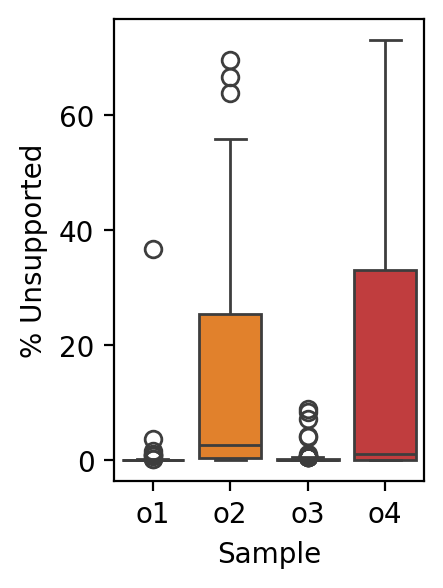

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3
sns.boxplot(data=result,
            x='sample_id',
            y='percent',
             hue='sample_id')

plt.ylabel('% Unsupported')
plt.xlabel('Sample')